In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
dtypes = {9: 'str',  11: 'str',  12: 'str', 13: 'str',23: 'str',29: 'str'}  
gwas_data= pd.read_csv("gwas_catalog_v1.0.2-associations_e110_r2023-09-25.tsv", sep= "\t", dtype= dtypes)

In [3]:
columns_to_delete = ['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL', 'LINK', 'STUDY', 
                     'INITIAL SAMPLE SIZE', 'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS', 'MAPPED_GENE',
                     'UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID', 'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'MERGED', 'SNP_ID_CURRENT','RISK ALLELE FREQUENCY','PVALUE_MLOG', 'P-VALUE (TEXT)', 'INTERGENIC', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV', 'SNP_GENE_IDS', 'MAPPED_TRAIT', 'STUDY ACCESSION', 'GENOTYPING TECHNOLOGY']
gwas_data.drop(columns=columns_to_delete, inplace=True)
gwas_data['EFO_ID'] = gwas_data['MAPPED_TRAIT_URI'].str.replace('http://www.ebi.ac.uk/efo/', '')
gwas_data.drop(columns=['MAPPED_TRAIT_URI'], inplace=True)

In [4]:
gwas_data.dropna(subset=['EFO_ID'], inplace=True)
gwas_data.dropna(subset=['REPORTED GENE(S)'], inplace=True)

The length of gwas data is: 264799
  DISEASE/TRAIT                   REPORTED GENE(S)       SNPS  \
0        Height                             ZBTB38  rs6763931   
1        Height                              ITM2A  rs1474563   
2        Height      COIL, RISK, NOG, DGKE, TRIM25  rs4794665   
3        Height                     L3MBTL3, SAMD3  rs6899976   
4        Height  DIS3L2, NPPC, COPS7B, PDE6D, PTMA   rs749052   

              CONTEXT       P-VALUE  OR or BETA       EFO_ID  
0      intron_variant  1.000000e-27         7.4  EFO_0004339  
1  intergenic_variant  3.000000e-06         3.5  EFO_0004339  
2  intergenic_variant  1.000000e-07         3.6  EFO_0004339  
3      intron_variant  6.000000e-06         3.8  EFO_0004339  
4  intergenic_variant  1.000000e-06         8.7  EFO_0004339  


In [6]:
#cancer workflow
from rdflib import Graph
import urllib.parse
import os
graph = Graph()

# File path
file_name = "efo-2.owl"
file_path = f"file://{urllib.parse.quote(os.path.abspath(file_name))}"

graph.parse(file_path)
from rdflib import RDF, OWL, RDFS, URIRef
for subject, predicate, obj in graph:
    if predicate == RDF.type and obj == OWL.Class:
        pass


import networkx as nx
from tqdm import tqdm
import numpy as np
nodes_all = list(graph.all_nodes())
disease_uri = URIRef('http://www.ebi.ac.uk/efo/EFO_0000408')
cancer_uri = URIRef('http://purl.obolibrary.org/obo/MONDO_0004992')

#Defining the queries, here we select data which has disease/cancer as an ancestor 
sparql_query_disease = f"""
    SELECT ?ancestor
    WHERE {{ ?ancestor <http://www.w3.org/2000/01/rdf-schema#subClassOf>* <{disease_uri}> }}
"""

sparql_query_cancer = f"""
    SELECT ?ancestor
    WHERE {{ ?ancestor <http://www.w3.org/2000/01/rdf-schema#subClassOf>* <{cancer_uri}> }}
"""

In [7]:
number_all = len(nodes_all)
print(f'# of all nodes: {number_all}')

# of all nodes: 656312


In [8]:
result_disease = graph.query(sparql_query_disease)
result_cancer= graph.query(sparql_query_cancer)
num_diseases = len(list(result_disease))
num_cancer=len(list(result_cancer))
print(f"Number of disease nodes: {num_diseases}")
print(f"Number of cancer nodes: {num_cancer}")

Number of disease nodes: 14665
Number of cancer nodes: 1139


In [9]:
disease_nodes = []
for row in result_disease:
    uri_string = str(row[0])
    if 'http://purl.obolibrary.org/obo/' in uri_string:
        identifier = uri_string.replace('http://purl.obolibrary.org/obo/', '')
    elif 'http://www.ebi.ac.uk/efo/' in uri_string:
        identifier = uri_string.replace('http://www.ebi.ac.uk/efo/', '')
    else:
        identifier = uri_string  

    disease_nodes.append(identifier)  
#this is all disease nodes in efo ontology



In [10]:
#exclude them from gwas data= traits data
traits = gwas_data[~gwas_data['EFO_ID'].isin(disease_nodes)]
length_traits1=len(traits)
print('The length of traits is:', length_traits1)

The length of traits is: 237154
                   DISEASE/TRAIT REPORTED GENE(S)         SNPS  \
11064       Lung function (FEV1)               NR    rs2638663   
11065       Lung function (FEV1)               NR    rs4673301   
11066       Lung function (FEV1)               NR    rs1494978   
11067       Lung function (FEV1)               NR   rs10220309   
11068       Lung function (FEV1)               NR    rs1441147   
...                          ...              ...          ...   
302705  Lung function (FEV1/FVC)            RPAP1    rs1200345   
302706      Lung function (FEV1)            RPRD2   rs41273537   
302707      Lung function (FEV1)           CHRNB2  rs202079239   
302708      Lung function (FEV1)           SEC24C    rs3849969   
302709      Lung function (FEV1)           CASC17    rs1859962   

                   CONTEXT       P-VALUE  OR or BETA       EFO_ID  
11064       intron_variant  8.000000e-07         NaN  EFO_0004314  
11065       intron_variant  4.000000e-0

In [11]:
traits = traits.drop_duplicates(subset=['DISEASE/TRAIT', 'SNPS'], keep='first')
length_traits2=len(traits)
diff= length_traits1-length_traits2
print(f'{diff} duplicates have been dropped from traits')

41015 duplicates have been dropped from traits


In [13]:
gwas_disease = gwas_data[gwas_data['EFO_ID'].isin(disease_nodes)]

length_diseases1=len(gwas_disease)
print('The length of diseases is is:', length_diseases1)

The length of diseases is is: 27645
              DISEASE/TRAIT REPORTED GENE(S)        SNPS  \
209             Lung cancer             GPC5   rs2352028   
1722            Lung cancer    TERT, CLPTM1L    rs402710   
1723            Lung cancer       intergenic   rs1051730   
2930    Lung adenocarcinoma             TP63  rs10937405   
2931    Lung adenocarcinoma             TERT   rs2736100   
...                     ...              ...         ...   
207031          Lung cancer          SLC30A8   rs3019885   
207032          Lung cancer       intergenic   rs6580649   
207033          Lung cancer       intergenic   rs7900823   
207034          Lung cancer  C6orf72, KATNA1   rs9322193   
207037  Lung adenocarcinoma             TERT   rs2853677   

                                   CONTEXT       P-VALUE  OR or BETA  \
209                         intron_variant  6.000000e-06    1.460000   
1722    non_coding_transcript_exon_variant  4.000000e-06    1.180000   
1723                    syn

In [14]:
gwas_disease = gwas_disease.drop_duplicates(subset=['DISEASE/TRAIT', 'SNPS'], keep='first')
length_diseases2=len(gwas_disease)

In [15]:
diff= length_diseases1-length_diseases2
print(f'{diff} duplicates have been dropped from gwas_disease')

4185 duplicates have been dropped from gwas_disease


In [29]:
G = nx.Graph()
diseases_list = list(gwas_disease['EFO_ID'])
traits_list = list(traits['EFO_ID'])

unique_diseases = set(diseases_list)
unique_traits = set(traits_list)

nodes = list(unique_diseases | unique_traits)
G.add_nodes_from(nodes)

{'EFO_0007961', 'EFO_0005686', 'EFO_0010559', 'EFO_0010817', 'EFO_0008237', 'EFO_0010114', 'EFO_0000764', 'EFO_0007929', 'EFO_0007613', 'EFO_0009861', 'EFO_0006329', 'EFO_0007849', 'EFO_0010151', 'EFO_0007009', 'EFO_0010394', 'EFO_0008469', 'EFO_0005139', 'EFO_1001249', 'EFO_0007676', 'EFO_0010428', 'EFO_0005852', 'EFO_0004572', 'EFO_0008338', 'EFO_0008593', 'EFO_0006504', 'EFO_0004915', 'EFO_0004642', 'EFO_0600003', 'MONDO_0006715', 'EFO_0010536', 'EFO_0010504', 'EFO_0006333', 'EFO_0010625', 'EFO_0004302', 'EFO_0004682', 'EFO_0009130', 'EFO_0005036', 'EFO_0006342', 'EFO_0008402', 'EFO_0009706', 'EFO_0000621', 'EFO_0010330', 'EFO_0004573', 'EFO_0008384', 'EFO_0005188', 'EFO_0005324', 'HP_0000738', 'HP_0001007', 'EFO_0010443', 'EFO_0004581', 'EFO_0006904', 'EFO_0006352', 'EFO_0004811', 'EFO_0001068', 'EFO_0009770', 'EFO_0009587', 'EFO_0004847', 'EFO_0010094', 'EFO_0005127', 'EFO_0007836', 'EFO_0005267', 'EFO_0010700', 'EFO_0005116', 'MONDO_0016158', 'EFO_0005674', 'EFO_0004274', 'EFO_00

In [30]:
from collections import defaultdict
#wanted to avoid nested dict, bottleneck
disease_snps_dict = defaultdict(set)
trait_snps_dict = defaultdict(set)

for index, row in gwas_disease.iterrows():
    snps = row['SNPS'].split()
    disease_snps_dict[row['EFO_ID']].update(snps)

for index, row in traits.iterrows():
    snps = row['SNPS'].split() 
    trait_snps_dict[row['EFO_ID']].update(snps)


In [31]:
for disease1, disease1_snps in disease_snps_dict.items():
    for disease2, disease2_snps in disease_snps_dict.items():
        if disease1 != disease2:  
            shared_snps = disease1_snps.intersection(disease2_snps)
            if len(shared_snps) > 1:
                G.add_edge(disease1, disease2, snps=list(shared_snps))

for trait1, trait1_snps in trait_snps_dict.items():
    for trait2, trait2_snps in trait_snps_dict.items():
        if trait1 != trait2:  # To avoid self-loops
            shared_snps = trait1_snps.intersection(trait2_snps)
            if len(shared_snps) > 1:
                G.add_edge(trait1, trait2, snps=list(shared_snps))
                
for disease, disease_snps in disease_snps_dict.items():
    for trait, trait_snps in trait_snps_dict.items():
        shared_snps = disease_snps.intersection(trait_snps)
        if len(shared_snps) > 1:
            G.add_edge(disease, trait, snps=list(shared_snps))


In [35]:
connected_components = list(nx.connected_components(G))
largest_connected_component = max(connected_components, key=len)

G_subgraph = G.subgraph(largest_connected_component)
node_colors = {}
for node in G_subgraph.nodes():
    if node in unique_diseases:
        node_colors[node] = 'red'  
    elif node in unique_traits:
        node_colors[node] = 'blue'

edge_colors = []
for edge in G_subgraph.edges():
    node1, node2 = edge
    if node1 in unique_diseases and node2 in unique_diseases:
        edge_colors.append('red')  
    elif (node1 in unique_diseases and node2 in unique_traits) or (node2 in unique_diseases and node1 in unique_traits):
        edge_colors.append('yellow')  
    elif node1 in unique_traits and node2 in unique_traits:
        edge_colors.append('blue') 

<IPython.core.display.Javascript object>


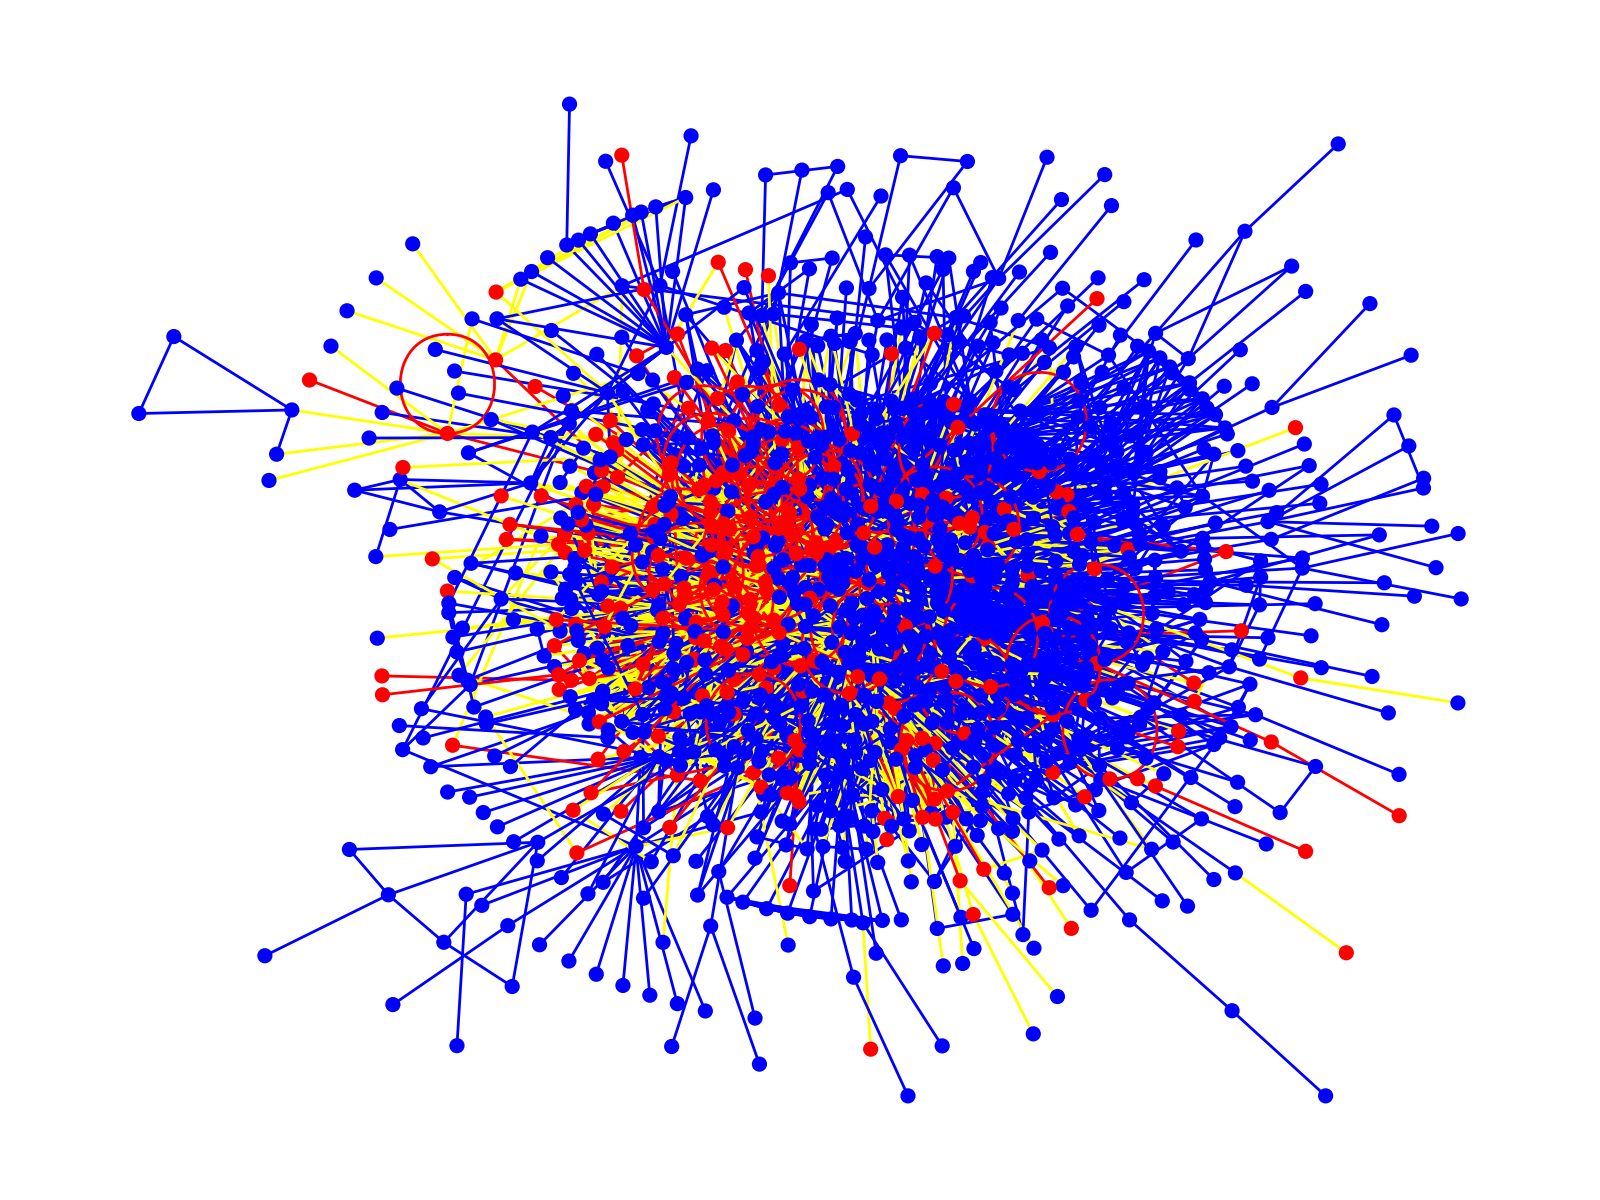

In [36]:
plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G_subgraph)
nx.draw(G_subgraph, pos, edge_color=edge_colors,node_color=[node_colors[node] for node in G_subgraph.nodes()], node_size=20, with_labels=False)
plt.title('Disease-Trait Network Shared w/ SNPS>1')
plt.show()

In [ ]:
###### NULL MODEL - SWITCH BASED RANDOMIZATION #######

num_randomizations = 1000
random_d_t_counts = []
random_d_d_counts = []
random_t_t_counts = []
number_of_edges = G.number_of_edges()
number_of_swaps = int(1 * number_of_edges) 
max_tries = 1000000

for _ in range(num_randomizations):
    G_swapped = nx.double_edge_swap(G.copy(), nswap=number_of_swaps, max_tries=max_tries)
    disease_trait_edges = []
    disease_disease_edges = []
    trait_trait_edges = []
    for edge in G_swapped.edges(data=True):
        node1, node2, data = edge
        if (node1 in disease_snps_dict and node2 in trait_snps_dict) or (node1 in trait_snps_dict and node2 in disease_snps_dict):
            disease_trait_edges.append(edge)

        elif (node1 in disease_snps_dict and node2 in disease_snps_dict):
            disease_disease_edges.append(edge)

        elif (node1 in trait_snps_dict and node2 in trait_snps_dict):
            trait_trait_edges.append(edge)


    num_disease_trait_edges = len(disease_trait_edges)
    random_d_t_counts.append(num_disease_trait_edges)
    num_disease_disease_edges = len(disease_disease_edges)
    random_d_d_counts.append(num_disease_disease_edges)
    num_trait_trait_edges = len(trait_trait_edges)
    random_t_t_counts.append(num_trait_trait_edges)
    print("Number of disease-trait edges:", num_disease_trait_edges)
    print("Number of disease-disease edges:", num_disease_disease_edges)
    print("Number of trait-trait edges:", num_trait_trait_edges)
    print("_________________")

In [1]:
###Z- SCORES###

mean = np.mean(random_trait_trait_edges)
std = np.std(random_trait_trait_edges)
z_score= (num_trait_trait_edges - mean)/std
print(z_score)
mean = np.mean(random_disease_disease_edges)
std = np.std(random_disease_disease_edges)
z_score1= (num_disease_disease_edges - mean)/std
print(z_score)
mean = np.mean(random_disease_trait_edges)
std = np.std(random_disease_trait_edges)
z_score1= (num_disease_trait_edges - mean)/std
print(z_score)

NameError: name 'np' is not defined